In [2]:
# 0. Link colab với Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [4]:
# 1. Tạo thư mục data/split_data và chạy lệnh chia train test
import os
import glob
import random
import shutil

raw_data_path = "/content/gdrive/MyDrive/data/raw_data/images"
train_data_path = "/content/gdrive/MyDrive/data/split_data/train"
test_data_path = "/content/gdrive/MyDrive/data/split_data/test"

if not os.path.exists("/content/gdrive/MyDrive/data/split_data/"):
  os.mkdir("/content/gdrive/MyDrive/data/split_data/")
  
try:
  shutil.rmtree(train_data_path)
  shutil.rmtree(test_data_path)
except:
  pass

os.mkdir(train_data_path)
os.mkdir(test_data_path)

total_files = glob.glob(raw_data_path + "/*.jpg")
print("Sample file = ", total_files[0])
print("Total file = ", len(total_files))

indices = list(range(len(total_files)))
train_indices = random.sample(indices, k = int(len(total_files)*0.9))
print("Total train file = ", len(train_indices))

for i in indices:
   
    if (i in train_indices):
        # Copy to train
        shutil.copy(total_files[i], train_data_path + total_files[i].replace(raw_data_path,""))
        shutil.copy(total_files[i].replace("images","labels").replace(".jpg",".xml"),
                    train_data_path + total_files[i].replace(raw_data_path, "").replace(".jpg",".xml"))
    else:
        # Copy to test
        shutil.copy(total_files[i], test_data_path + total_files[i].replace(raw_data_path, ""))
        shutil.copy(total_files[i].replace("images", "labels").replace(".jpg", ".xml"),
                    test_data_path + total_files[i].replace(raw_data_path, "").replace(".jpg",".xml"))



Sample file =  /content/gdrive/MyDrive/data/raw_data/images/265.jpg
Total file =  388
Total train file =  349


In [5]:

# 3.Convert XML label sang CSV. File CSV lưu trong thư mục split_data
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

for directory in ['train','test']:
        image_path = os.path.join('/content/gdrive/MyDrive/data/split_data/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('/content/gdrive/MyDrive/data/split_data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')

Successfully converted xml to csv.
Successfully converted xml to csv.


In [6]:
# 4. Tải TF Object Detection APi vào thư mục models
%cd /content/gdrive/MyDrive
!git clone https://github.com/tensorflow/models.git

[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content/gdrive/MyDrive
Cloning into 'models'...
remote: Enumerating objects: 68293, done.
remote: Total 68293 (delta 0), reused 0 (delta 0), pack-reused 68293
Receiving objects: 100% (68293/68293), 576.51 MiB | 12.21 MiB/s, done.
Resolving deltas: 100% (47983/47983), done.
Checking out files: 100% (2980/2980), done.


In [8]:
# 5. Compile the protos -  
# Protocol Buffers (Protobuf) is a free and open-source cross-platform data format used to serialize structured data.
%cd /content/gdrive/MyDrive/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/MyDrive/models/research


In [9]:
# 6. Cài dặt API
%cd /content/drive/MyDrive/models/research
!cp object_detection/packages/tf2/setup.py . 
!python -m pip install .


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# 7. Test API
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
# 8. CSV to TFRecord. With help from MiAI git hub
%cd /content/gdrive/MyDrive/models/research
!git clone https://github.com/thangnch/MiAI_SSD_TF2
!cp MiAI_SSD_TF2/generate_tfrecord.py .
!cp MiAI_SSD_TF2/label_map.txt /content/gdrive/MyDrive/data

if not os.path.exists("/content/gdrive/MyDrive/data/tfrecord_data/"):
  os.mkdir("/content/gdrive/MyDrive/data/tfrecord_data/")

!python generate_tfrecord.py --image_dir=/content/gdrive/MyDrive/data/split_data/train --csv_input=/content/gdrive/MyDrive/data/split_data/train_labels.csv --output_path=/content/gdrive/MyDrive/data/tfrecord_data/train.record 
!python generate_tfrecord.py --image_dir=/content/gdrive/MyDrive/data/split_data/test --csv_input=/content/gdrive/MyDrive/data/split_data/test_labels.csv --output_path=/content/gdrive/MyDrive/data/tfrecord_data/test.record 


In [ ]:
# 9. Download pretrain and config
if not os.path.exists("/content/gdrive/MyDrive/pretrained"):
  os.mkdir("/content/gdrive/MyDrive/pretrained")

%cd /content/gdrive/MyDrive/pretrained
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
# Unzip
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Config pipeline.config, label_map.txt if needed

In [ ]:
# Upload label file object-detection.txt to data folder
%cd /content/gdrive/MyDrive/models
!pip install -r /content/gdrive/MyDrive/models/research/MiAI_SSD_TF2/setup.txt
!pip install --upgrade opencv-python

In [ ]:
# Train
%cd /content/gdrive/MyDrive/models/research
%cp /content/gdrive/MyDrive/models/research/object_detection/model_main_tf2.py .

#train 
!python model_main_tf2.py \
--pipeline_config_path=/content/gdrive/MyDrive/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--model_dir=/content/gdrive/MyDrive/output_model --alsologtostderr --num_train_steps=1000

In [ ]:
# Export model
%cd /content/gdrive/MyDrive/models/research
%cp /content/gdrive/MyDrive/models/research/object_detection/exporter_main_v2.py .

!python exporter_main_v2.py \
--trained_checkpoint_dir=/content/gdrive/MyDrive/output_model \
--pipeline_config_path=/content/gdrive/MyDrive/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--output_directory=/content/gdrive/MyDrive/export_model

In [18]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#Load model
tf.keras.backend.clear_session()
model = tf.saved_model.load("/content/gdrive/MyDrive/export_model/saved_model")

In [19]:
# Các hàm inference

import cv2
def run_inference_for_single_image(model, image):
  
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

/content/gdrive/MyDrive/models/research
Done load image 
Done inference
Done draw on image 


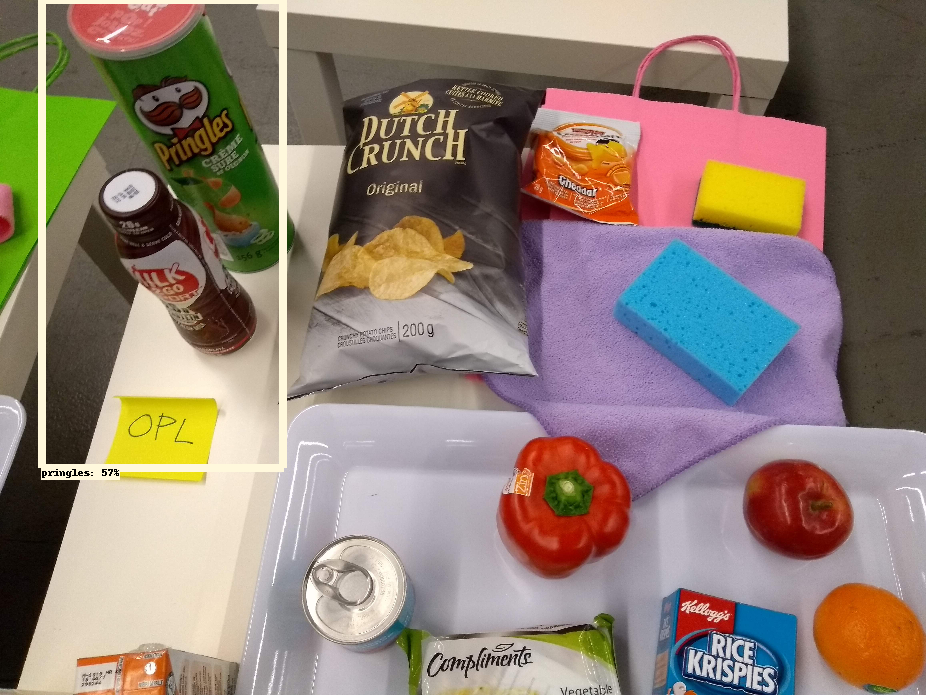

In [22]:
%cd /content/gdrive/MyDrive/models/research
category_index = label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/data/label_map.txt", use_display_name=True)

image_path = '/content/gdrive/MyDrive/data/split_data/train/2.jpg'
image_np = load_image_into_numpy_array(image_path)
print("Done load image ")
image_np = cv2.resize(image_np, dsize=None, fx=0.2, fy=0.2)
output_dict = run_inference_for_single_image(model, image_np)
print("Done inference")
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
print("Done draw on image ")
display(Image.fromarray(image_np))